# Intersect over Union score for multi-label, multi-class classification

In [2]:
from pyclouds import iou
from pyclouds.imports import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Simple IoU for two boxes

The basic IoU score for two objects is simply

<img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png" width="400">

In the annotations we are using the coordinate convention: x of bottom left, y of bottom left, width, height

In [152]:
# Create example boxes
a1 = [50, 50, 400, 400]
a2 = [10, 10, 300, 300]
a3 = [600, 600, 20, 20]

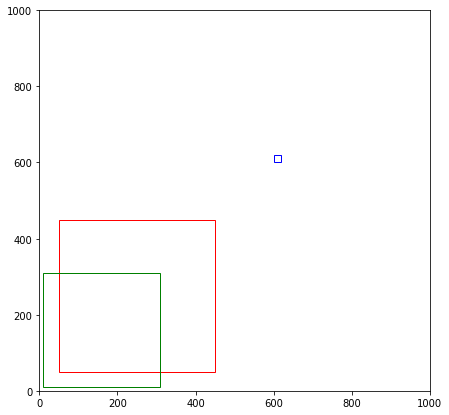

In [153]:
# Plot example boxes
fig, ax = plt.subplots(figsize=(7, 7))
for a, c in zip([a1, a2, a3], ['r', 'g', 'b']):
    rect = patches.Rectangle((a[0],a[1]), a[2], a[3], facecolor='none', edgecolor=c)
    ax.add_patch(rect)
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000);

To compute the IoU, we first compute the intersect between the two boxes.

To compute the union, we can simply compute the sum of the two areas and subtract the intersect (which you count twice by adding the sums).

In [154]:
# Compute IoU
# 1. Intersect between two boxes
I = iou.compute_intersect(a1, a2)
# 2. Then compute the sum of the areas and subtract the intersect
U = iou.compute_area_sum([a1, a2]) - I
# Finally, divede I by U
I, U, I/U

(67600, 182400, 0.3706140350877193)

In [155]:
# Test two identical boxes
I = iou.compute_intersect(a1, a1)
U = iou.compute_area_sum([a1, a1]) - I
I/U

1.0

In [156]:
# Test two boxes that do not overlap
I = iou.compute_intersect(a1, a3)
U = iou.compute_area_sum([a1, a3]) - I
I/U

0.0

## A different way of computing IoU - the brute force way

The method above works great in simple cases. Going to the multi-label case however is really tricky because a lot of special cases have to be considered, such as overlapping boxes of one or both users. I think it is possible just using the box edge coordinates but I struggled for too long. 

So we will just use the brute force approach. We will simply create an array with the same dimensions as the image and fill in the boxes.

In [157]:
def fill_array_with_boxes(annos, img_size):
    """
    Creates an array where all areas of the array that are in one of the boxes are True, otherwise False
    """
    arr = np.zeros(img_size, dtype=bool)
    for a in annos:
        arr[a[0]:a[0]+a[2], a[1]:a[1]+a[3]] = True
    return arr

In [158]:
def intersect_from_arrs(arr1, arr2):
    return np.sum(np.bitwise_and(arr1, arr2))
def union_from_arrs(arr1, arr2):
    return np.sum(np.bitwise_or(arr1, arr2))
def iou_one_class_from_arrs(arr1, arr2):
    return intersect_from_arrs(arr1, arr2) / union_from_arrs(arr1, arr2)
def iou_one_class_from_annos(annos1, annos2, img_size):
    return iou_one_class_from_arrs(
        fill_array_with_boxes(annos1, img_size), fill_array_with_boxes(annos2, img_size))

In [161]:
iou_one_class_from_annos([a1], [a2], (1000, 1000)), \
iou_one_class_from_annos([a1], [a1], (1000, 1000)), \
iou_one_class_from_annos([a1], [a3], (1000, 1000))

(0.3706140350877193, 1.0, 0.0)

## Multi-label case

Next we will simulate the case where the two "users" draw several boxes. For now let's assume that there is only one class.

In [71]:
# Again let's create an example
annos1 = [[0, 0, 3, 3], [5, 5, 2, 2]]
annos2 = [[1, 1, 3, 3], [2, 2, 5, 5], [6, 6, 3, 3]]
# Easy example 1: I = 12, U = 37
annos1 = [[0, 0, 4, 4], [3, 3, 3, 3]]   # For only annos1: I = U = 24
annos2 = [[2, 2, 5, 5]]

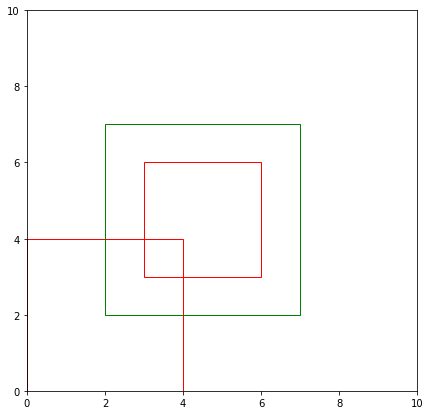

In [72]:
# And plot it
# Plot example boxes
fig, ax = plt.subplots(figsize=(7, 7))
for annos, c in zip([annos1, annos2], ['r', 'g']):
    for a in annos:
        rect = patches.Rectangle((a[0],a[1]), a[2], a[3], facecolor='none', edgecolor=c)
        ax.add_patch(rect)
ax.set_xlim(0, 10); ax.set_ylim(0, 10);

Here it becomes a bigger challenge to compute the intersect and union.

First we 

In [131]:
annos1

[[0, 0, 4, 4], [3, 3, 3, 3]]

In [147]:
z1 = np.zeros((10, 10), dtype=bool)
for a in annos1:
    z1[a[0]:a[0]+a[2], a[1]:a[1]+a[3]] = True
z2 = np.zeros((10, 10), dtype=bool)
for a in annos1:
    z2[a[0]:a[0]+a[2], a[1]:a[1]+a[3]] = True
z_i = np.bitwise_and(z1, z2)
z_u = np.bitwise_or(z1, z2)
np.sum(z_i), np.sum(z_u)

(24, 24)

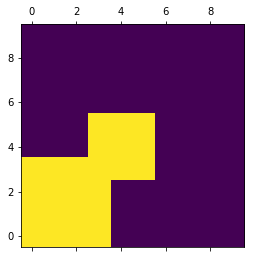

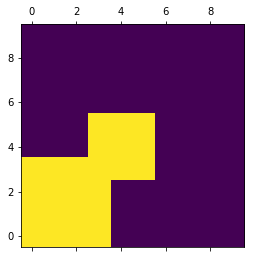

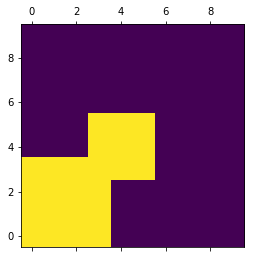

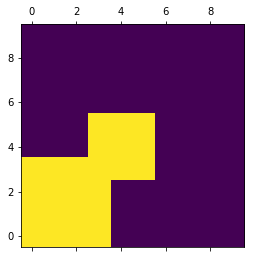

In [148]:
plt.matshow(z1, origin='lower')
plt.matshow(z2, origin='lower')
plt.matshow(z_i, origin='lower')
plt.matshow(z_u, origin='lower')

In [106]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

def compute_intersect_tmp(a1, a2):
    """
    https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    Computes the intersect between two boxes.
    """
    x1a, y1a, x2a, y2a = wh2xy(*a1)
    x1b, y1b, x2b, y2b = wh2xy(*a2)
    xA = max(x1a, x1b)
    yA = max(y1a, y1b)
    xB = min(x2a, x2b)
    yB = min(y2a, y2b)
    i = max(0, xB - xA) * max(0, yB - yA) # max(0, xB - xA + 1) * max(0, yB - yA + 1)
    return i, [xA, yA, xB, yB]

In [101]:
compute_intersect_tmp(annos1[0], annos1[0]), annos1[0]

((16, 0, 0, 4, 4), [0, 0, 4, 4])

In [117]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

def xy2wh(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

In [121]:
i = 0
intersects = []
for a1 in annos1:
    for a2 in annos1:
        r = compute_intersect_tmp(a1, a2)
        i += r[0]
        intersects.append(xy2wh(*r[1]))

In [122]:
i

27

In [123]:
intersects

[(0, 0, 4, 4), (3, 3, 1, 1), (3, 3, 1, 1), (3, 3, 3, 3)]

In [130]:
ii = 0
for i1, i2 in itertools.combinations(intersects, 2):
    print(i1, i2, compute_intersect(i1, i2))
    ii += compute_intersect(i1, i2)
ii, ii // 2

(0, 0, 4, 4) (3, 3, 1, 1) 1
(0, 0, 4, 4) (3, 3, 1, 1) 1
(0, 0, 4, 4) (3, 3, 3, 3) 1
(3, 3, 1, 1) (3, 3, 1, 1) 1
(3, 3, 1, 1) (3, 3, 3, 3) 1
(3, 3, 1, 1) (3, 3, 3, 3) 1


(6, 3)

In [129]:
for i1, i2 in itertools.combinations([0, 1, 2, 3], 2):
    print(i1, i2)

0 1
0 2
0 3
1 2
1 3
2 3


In [89]:
from pyclouds.iou import compute_intersect, compute_area_sum
import pdb
def iou_one_class_tmp(annos1, annos2):
    pdb.set_trace()
    """annos1 and annos2 are lists with the coordinates of each annotation"""
    # All permutations
    i_tmp = 0
    for a1 in annos1:
        for a2 in annos2:
            i_tmp += compute_intersect(a1, a2)
    # Need to compute the overlap between the boxes of 1 and 2
    i1 = 0; i2 = 0
    for b1, b2 in itertools.combinations(annos1, 2):
        i1 += compute_intersect(b1, b2)
    for b1, b2 in itertools.combinations(annos2, 2):
        i2 += compute_intersect(b1, b2)
        
    i = i_tmp - i1 - i2
    i3 = 0
    for b1, b2 in itertools.combinations(annos1 + annos2, 2):
        i3 += compute_intersect(b1, b2)
    u = compute_area_sum(annos1 + annos2) - i_tmp #- i3
    
    iou = i/u  #(i - i1 - i2) / u
    return i, u, iou

In [90]:
i, u = iou.iou_one_class(annos1, annos1)
i, u, i/u, iou_one_class_tmp(annos1, annos1)

> <ipython-input-89-7f1e2b7d51db>(7)iou_one_class_tmp()
-> i_tmp = 0
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(8)iou_one_class_tmp()
-> for a1 in annos1:
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(10)iou_one_class_tmp()
-> i_tmp += compute_intersect(a1, a2)
(Pdb) p a1, a2
([0, 0, 4, 4], [0, 0, 4, 4])
(Pdb) compute_intersect(a1, a2)
16
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) i_tmp
16
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(10)iou_one_class_tmp()
-> i_tmp += compute_intersect(a1, a2)
(Pdb) p a1, a2
([0, 0, 4, 4], [3, 3, 3, 3])
(Pdb) compute_intersect(a1, a2)
1
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) i_tmp
17
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(8)iou_one_class_tmp()
-> for a1 in annos1:
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) n
> <ipython-input-89-

BdbQuit: 